In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size':15})
import sys
sys.path.insert(1, '/home/a/a270230/LKF/lkf_detection/functions/')
from statistics_functions import *
from pyproj import Proj

In [2]:
res = '1km'

path = '/work/bk1377/a270230/'
path_stat = path + 'statistics/'
path_nc   = path + f'interpolated_fesom_output/{res}/'
path_imgs = path + 'imgs/'

In [3]:
if True:
    # use the already calculated horizontal resolutions (so the nc files don't need to be saved)
    if res == '4km': res_km = 4.337849218906646
    if res == '1km': res_km = 1.083648783567869
else:
    # calculate the horizonatal resolution from the nc files
    year = 2095
    file = xr.open_dataset(path_nc + f'{year}_{res}.nc')

    lon = file.ULON
    lat = file.ULAT

    m = Proj(proj='stere',lat_0=90, lat_ts=70, lon_0=-45, ellps='WGS84')

    x, y = m(lon, lat)
    dxu = np.sqrt((x[:,1:]-x[:,:-1])**2 + (y[:,1:]-y[:,:-1])**2)
    dxu = np.concatenate([dxu,dxu[:,-1].reshape((dxu.shape[0],1))],axis=1)
    dyu = np.sqrt((x[1:,:]-x[:-1,:])**2 + (y[1:,:]-y[:-1,:])**2)
    dyu = np.concatenate([dyu,dyu[-1,:].reshape((1,dyu.shape[1]))],axis=0)

    res_km = 0.5 * (np.mean(dxu) + np.mean(dyu)) / 1000

res_km

1.083648783567869

In [4]:
if False:
    years = [i for i in range(2013,2021)]
    years += [i for i in range(2093,2101)]

if False:
    # for the statistical analysis, only the total area is needed
    area_total = []
    for year in years:
        file = xr.open_dataset(path_nc + f'{year}_{res}.nc')
        area_total += np.nansum(file.A, axis=(1,2)) * res_km**2,
        
    np.save(path_stat + f'area_total_{res}', np.array([area_total, years], dtype='object'))

if False:
    # this is for creating the plots below. it requires
    # that the ice thickness is included in the nc files
    [a_mean, area_total, h_mean, vol_total] = [[] for _ in range(4)]
    for year in years:
        file = xr.open_dataset(path_nc + f'{year}_{res}.nc')

        a_mean += np.nanmean(file.A, axis=(1,2)),
        area_total += np.nansum(file.A, axis=(1,2)) * res_km**2,

        ice = file.H
        ice = np.where(ice>0,ice,np.nan)

        h_mean += np.nanmean(ice, axis=(1,2)),
        vol_total += np.nanmean(ice * dxu * dyu, axis=(1,2)),
        
    np.save(path_stat + f'a_mean_tot_h_mean_tot_{res}',
            np.array([a_mean, area_total, h_mean, vol_total, years], dtype='object'))

In [5]:
# load mean ice concentration, total ice covered area, mean ice thickness,
# and total ice volume for all years of the model run (1986 - 2100 for 4km,
# 2013 - 2020 & 2093 - 2100 for 1km)
[a_mean, area_total, h_mean, vol_total, years_all] = np.load(
    path_stat + f'a_mean_tot_h_mean_tot_{res}.npy', allow_pickle=True)

# select the years you want to analyze
years = [i for i in range(2013,2021)]
years += [i for i in range(2093,2101)]
inds = [np.where(years_all==year)[0][0] for year in years]

# make an array of the right np.shape out of the variables
def recreate(var):
    arr = np.zeros((len(var),365))
    for year, var_y in enumerate(var):
        arr[year,:] = var_y
    return arr

a_mean     = recreate(a_mean[inds])
area_total = recreate(area_total[inds])
h_mean     = recreate(h_mean[inds])
vol_total  = recreate(vol_total[inds])

In [6]:
def plot(var, ylabel):
    '''plot the individual years of the variable var for the two
    time periods.
    light -> dark <=> beginning -> end of the time period
    '''
    
    color_range = np.linspace(0, 100, 8)
    norm = plt.Normalize(vmin=-50, vmax=100)
    cmap = plt.cm.Blues
    cmap2 = plt.cm.Oranges
    
    for var_y, color in zip(var[:8], color_range):
        plt.plot(var_y, color = cmap(norm(color)))

    for var_y, color in zip(var[8:], color_range):
        plt.plot(var_y, color = cmap2(norm(color)))


    plt.grid()
    p1 = mpatches.Patch(color='tab:blue', label='2013 - 2020')
    p2 = mpatches.Patch(color='tab:orange', label='2093 - 2100')
    plt.legend(handles=[p1, p2])
    plt.xlim([0,365])
    plt.xticks(xticks,[])
    plt.xticks(xticks_minor,xticks_labels, rotation=70, minor=True)
    plt.ylabel(ylabel)

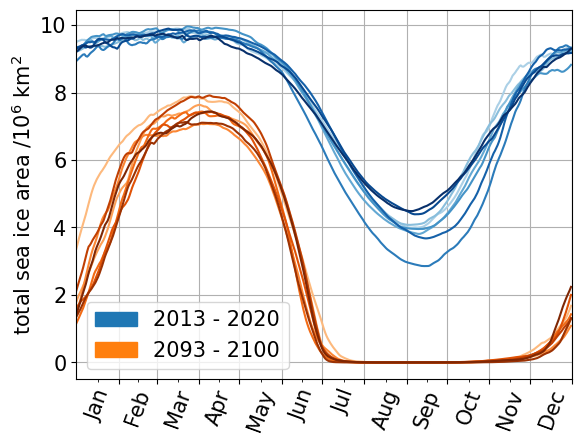

In [7]:
plot(area_total/1e6, r'total sea ice area /10$^6$ km$^2$')
#plt.savefig(path_imgs + 'area_total.png', dpi=100, bbox_inches='tight')

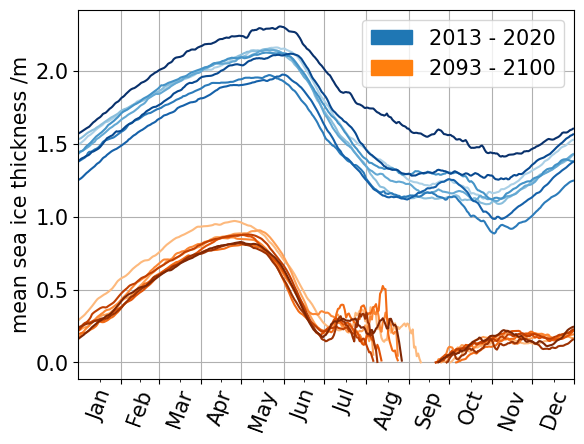

In [8]:
plot(h_mean, 'mean sea ice thickness /m')
#plt.savefig(path_imgs + 'h_mean.png', dpi=100, bbox_inches='tight')

In [9]:
def plot2(var, ylabel):
    '''plot the interannual mean of the variable var with its standart
    deviation for the two time periods
    '''
    
    for ystart, yend in zip([2013,2093], [2020,2100]):
        var_av, var_sd         = av_sd(var, ystart, yend, years)
        
        plt.plot(var_av,label=f'{ystart} - {yend}')
        plt.fill_between(np.arange(len(var_av)), var_av-var_sd, var_av+var_sd, alpha=0.5)

    plt.grid()
    plt.legend()
    plt.xlim([0,365])
    plt.xticks(xticks,[])
    plt.xticks(xticks_minor,xticks_labels, rotation=70, minor=True)
    plt.ylabel(ylabel)

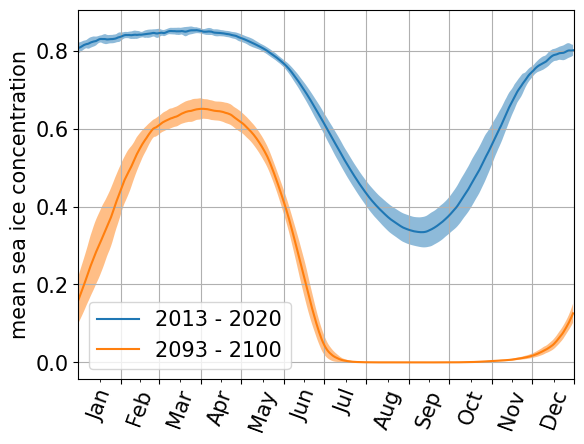

In [10]:
plot2(a_mean, 'mean sea ice concentration')
#plt.savefig(path_imgs + 'a_mean_av.png', dpi=100, bbox_inches='tight')

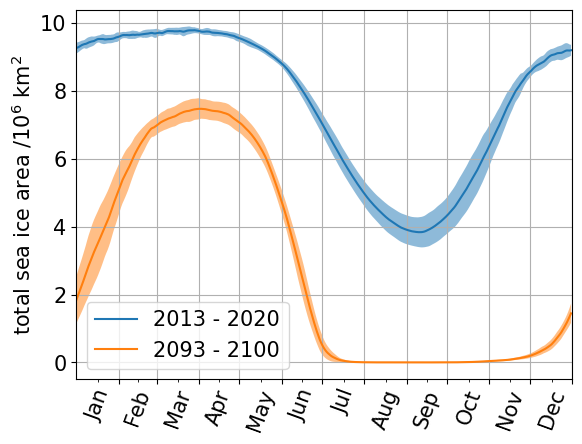

In [11]:
plot2(area_total/1e6, r'total sea ice area /10$^6$ km$^2$')
#plt.savefig(path_imgs + 'area_total_av.png', dpi=100, bbox_inches='tight')

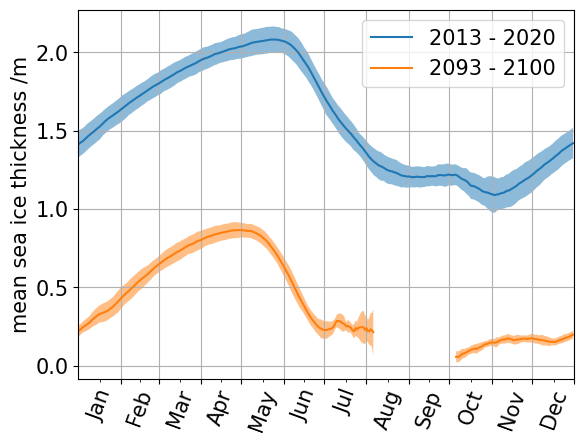

In [12]:
plot2(h_mean, 'mean sea ice thickness /m')
#plt.savefig(path_imgs + 'h_mean_av.png', dpi=100, bbox_inches='tight')